<a href="https://colab.research.google.com/github/makataomu/NFactorial_2023/blob/main/NFact.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, we will do a little preprocessing of our data, we will combine the words in all the passages as one large corpus, remove numeric values if any, and double spaces.

Также можно lowercase на все и брать только уникальные имена

In [ ]:
def preprocess(self):
    output = ""
    for file in self.texts:
        with open(os.path.join(os.getcwd(), file), 'r', encoding="utf-8-sig", errors='ignore') as suffix:
            sentence = suffix.read().split('\n')
            for line in sentence:
                output += " " + line
    return output

# BIgram LM

Читаем данные и делаем preprocessing

In [ ]:
with open("/content/drive/MyDrive/Colab Notebooks/names.txt", "r", encoding="utf-8-sig", errors='ignore') as f:
    names = f.read().splitlines()

# Convert names to lowercase and remove duplicates
names = list(set([name.lower() for name in names]))

In [ ]:
import random
from collections import defaultdict

def build_bigram_model(names):
    """
    Builds a bigram model from the given list of names and returns a dictionary
    where the keys are bigrams and the values are the probabilities of those
    bigrams.
    """
    bigram_counts = {}
    total_count = 0
    for name in names:
      # add "^" at the beginning and "$" at the end of each name
      name = "^" + name + "$"
      for i in range(len(name)-1):
          bigram = (name[i], name[i + 1])
          if bigram in bigram_counts:
              bigram_counts[bigram] += 1
          else:
              bigram_counts[bigram] = 1
          total_count += 1

    bigram_probs = {bigram: count / total_count for bigram, count in bigram_counts.items()}
    return bigram_probs

def generate_name(bigram_probs):
    """
    Generates a new name based on the given bigram probabilities.
    """
    name = ""
    # Choose the first letter randomly
    letters = list(bigram_probs.keys())
    while not name:
        letter = random.choice(letters)
        if letter[0] == "^":
            name += letter[1]
    # Keep adding letters based on bigram probabilities until we hit the end
    #print(name)
    name_length = 0
    while name_length < 10:
        possible_next_letters = [letter[1] for letter in bigram_probs if letter[0] == name[-1]]
        if not possible_next_letters:
            break
        #print(name[-1])
        #print(possible_next_letters)
        mean_prob = sum(bigram_probs[(name[-1], letter)] for letter in possible_next_letters) / len(possible_next_letters) 
        probabilities = [bigram_probs[(name[-1], letter)] if bigram_probs[(name[-1], letter)] > mean_prob else 0 for letter in possible_next_letters]

        #print(probabilities)
        next_letter = random.choices(possible_next_letters, weights=probabilities)[0]
        if (next_letter == '$'):
          if name_length > 3:
            break
          else: 
            continue
        name += next_letter
        name_length += 1
    # Strip out the "^" and "$" markers
    return name[:-1]


bigram_probs = build_bigram_model(names)

# Generate a new name


In [ ]:
new_names = ""
for i in range(10):
  new_name = generate_name(bigram_probs)
  print(new_name)
  new_names += new_name + " "

rilenn
rilah
zynil
wnninainis
phelisi
teree
ynei
gamaliliri
qushalesos
uaianel


In [ ]:
import pandas as pd

def test_lengths(bigram_probs, variants, mean_procent=1, min_length=4, names_num=10, len_range=(6,10)):
    """
    Generates different name variants based on the given bigram probabilities and returns
    a DataFrame where columns are different variants and below in rows names.
    """
    
    # Variants based on maximum length
    for max_length in range(len_range[0], len_range[1]):
        test_names = []
        for i in range(names_num):
            name = ""
            # Choose the first letter randomly
            letters = list(bigram_probs.keys())
            while not name:
                letter = random.choice(letters)
                if letter[0] == "^":
                    name += letter[1]
            # Keep adding letters based on bigram probabilities until we hit the end
            name_length = 1
            while name_length < max_length:
                possible_next_letters = [letter[1] for letter in bigram_probs if letter[0] == name[-1]]
                if not possible_next_letters:
                    break

                mean_prob = sum(bigram_probs[(name[-1], letter)] for letter in 
                                possible_next_letters) / len(possible_next_letters) 

                mean_prob *= mean_procent
                probabilities = [bigram_probs[(name[-1], letter)] 
                                 if bigram_probs[(name[-1], letter)] > mean_prob 
                                 else 0 for letter in possible_next_letters]
                # Здесь выдается лист с одним элементом, поэтому добавляем индекс 0
                next_letter = random.choices(possible_next_letters, weights=probabilities)[0] 
                #print(next_letter)
                if (next_letter == '$'):
                    if name_length > min_length:
                        break
                    else: 
                        continue
                name += next_letter
                name_length += 1

                if (next_letter == name[-2]):
                  possible_next_letters = [letter[1] for letter in bigram_probs if letter[0] == name[-1] 
                                           if letter != next_letter and 
                                           letter != '$']
                  #print(possible_next_letters)                        
                  mean_prob = sum(bigram_probs[(name[-1], letter)] for letter in 
                                  possible_next_letters) / len(possible_next_letters) 

                  probabilities = [bigram_probs[(name[-1], letter)] if bigram_probs[(name[-1], letter)] > mean_prob 
                                   else 0 for letter in possible_next_letters]

                  next_letter = random.choices(possible_next_letters, weights=probabilities)[0] 
                  
                  name += next_letter
                  name_length += 1

            # Уберем $
            name = name[:-1]
            test_names.append(name)
        variants[f"max_length_{max_length}"] = test_names
    return variants

def test_most_probable(bigram_probs, variants):
    # Variants based on 1 maximum probability
    test_names = []
    for i in range(10):
        name = ""
        # Choose the first letter randomly
        letters = list(bigram_probs.keys())
        while not name:
            letter = random.choice(letters)
            if letter[0] == "^":
                name += letter[1]
        # Keep adding letters based on bigram probabilities until we hit the end
        name_length = 1
        while name_length < 10:
            possible_next_letters = [letter[1] for letter in bigram_probs if letter[0] == name[-1]]
            if not possible_next_letters:
                break
            max_prob = max([bigram_probs[(name[-1], letter)] for letter in possible_next_letters])
            max_prob_letters = [letter for letter in possible_next_letters if bigram_probs[(name[-1], letter)] == max_prob]
            #print("ifs")
            if max_prob_letters:
                next_letter = random.choice(max_prob_letters)
            else:
                probabilities = [bigram_probs[(name[-1], letter)] for letter in possible_next_letters]
                next_letter = random.choices(possible_next_letters, weights=probabilities)[0]
            #print("dollar")
            if (next_letter == '$'):
                if name_length > 4:
                    #print("breac")
                    break
                else: 
                    max_prob = max([bigram_probs[(name[-1], letter)] for letter in possible_next_letters if letter != '$'])
                    max_prob_letters = [letter for letter in possible_next_letters if bigram_probs[(name[-1], letter)] == max_prob]
                    next_letter = random.choice(max_prob_letters)

            name += next_letter
            name_length += 1
        # Уберем $
        name = name[:-1]
        test_names.append(name)
    variants["max_prob_1"] = test_names
    return variants

In [ ]:
def test_most_probable(bigram_probs, variants):
    # Variants based on 1 maximum probability
    test_names = []
    for i in range(10):
        name = ""
        # Choose the first letter randomly
        letters = list(bigram_probs.keys())
        while not name:
            letter = random.choice(letters)
            if letter[0] == "^":
                name += letter[1]
        # Keep adding letters based on bigram probabilities until we hit the end
        name_length = 1
        while name_length < 10:
            possible_next_letters = [letter[1] for letter in bigram_probs if letter[0] == name[-1]]
            if not possible_next_letters:
                break
            max_prob = max([bigram_probs[(name[-1], letter)] for letter in possible_next_letters])
            max_prob_letters = [letter for letter in possible_next_letters if bigram_probs[(name[-1], letter)] == max_prob]
            #print("ifs")
            if max_prob_letters:
                next_letter = random.choice(max_prob_letters)
            else:
                probabilities = [bigram_probs[(name[-1], letter)] for letter in possible_next_letters]
                next_letter = random.choices(possible_next_letters, weights=probabilities)[0]

            if (next_letter == '$'):
                if name_length > 4:
                    #print("breac")
                    break
                else: 
                    max_prob = max([bigram_probs[(name[-1], letter)] for letter in possible_next_letters if letter != '$'])
                    max_prob_letters = [letter for letter in possible_next_letters if bigram_probs[(name[-1], letter)] == max_prob]
                    next_letter = random.choice(max_prob_letters)

            name += next_letter
            name_length += 1
        # Уберем $
        name = name[:-1]
        test_names.append(name)
    variants["max_prob_1"] = test_names
    return variants


In [ ]:
def test_x_probable(bigram_probs, variants):
    # Variants based on 3-5 maximum probabilities
    for probable_letters in range(6, 9):
      test_names = []
      for i in range(10):
        name = ""
        # Choose the first letter randomly
        letters = list(bigram_probs.keys())
        while not name:
            letter = random.choice(letters)
            if letter[0] == "^":
                name += letter[1]
        name_length = 1

        while name_length < 8:
            # Add letters based on bigram probabilities until we hit the end
            possible_next_letters = [letter[1] for letter in bigram_probs if letter[0] == name[-1]]
            if not possible_next_letters:
                break

            probabilities = [bigram_probs[(name[-1], letter)] for letter in possible_next_letters]
            top_prob_indices = sorted(range(len(probabilities)), 
                                      key=lambda i: probabilities[i], reverse=True)[:probable_letters]
            top_prob_letters = [possible_next_letters[i] for i in top_prob_indices]
            next_letter = random.choice(top_prob_letters)

            if (next_letter == '$'):
                if name_length > 4:
                    break
                else: 
                    continue

            name += next_letter
            name_length += 1

            if (next_letter == name[-2]):
              top_prob_letters = [possible_next_letters[i] for i in top_prob_indices 
                                  if possible_next_letters[i] != next_letter and
                                  possible_next_letters[i] != '$']
              next_letter = random.choice(top_prob_letters)
              name += next_letter
              name_length += 1

        name = name[:-1]
        test_names.append(name)

      variants[f"max_probs_{probable_letters}"] = test_names

    return variants

In [ ]:
variants = {}
variants = test_lengths(bigram_probs, variants)
variants = test_most_probable(bigram_probs, variants)
variants = test_x_probable(bigram_probs, variants)

In [ ]:
# Add all variants to a DataFrame
import pandas as pd
df = pd.DataFrame(variants)

# Output the DataFrame
print(df)

  max_length_6 max_length_7 max_length_8 max_length_9 max_prob_1 max_probs_6  \
0         cenn       namela          ill         fron       nana       alyly   
1         rest        larah         kond        jesam      lelel     vereyee   
2         tend        hanes      ienndro        danar       pana     zaheena   
3       peyann         nila      uahiare        renam       cana    kilinenn   
4       maninn         weia         foli         eeer       vian     laholis   
5        onnan         yahe      braisel        quman       cana     falylee   
6        vayar       pariah       eliala         eren       nana     zisaynn   
7        kalee       wahiah         hele     chanisil       jana       liele   
8        uriah        rolyl         zonn       ganeri       hana        bely   
9        cises        telie         ynah       haiene       hana       rouar   

  max_probs_7 max_probs_8  
0     nalayna     ckeyrle  
1     rrerera       aynya  
2     eystori     clamodd  
3     y

In [ ]:
variants = test_lengths(bigram_probs, variants, mean_procent=1.3)
df = pd.DataFrame(variants)
print(df)

  max_length_6 max_length_7 max_length_8 max_length_9 max_prob_1 max_probs_6  \
0        ahiah        sinia      isoryly      viliaya       nana       alyly   
1         jaro         stri          ell     gahahele      lelel     vereyee   
2        eyahi       enamal       weneni     silenall       pana     zaheena   
3        xinay       jeriar        oneri         lyai       cana    kilinenn   
4        quama         kahi      bryaror        rilly       vian     laholis   
5        yahay        ralya       tenndr        elana       cana     falylee   
6        isela       enaiss      aieynan         inil       nana     zisaynn   
7        jahel       usorel      ghalenn        keney       jana       liele   
8        nieri       famela      aieynai       finayn       hana        bely   
9        chaha       ayneli        oliel     miahelie       hana       rouar   

  max_probs_7 max_probs_8  
0     nalayna     ckeyrle  
1     rrerera       aynya  
2     eystori     clamodd  
3     y

# получить таблицу визуализирующие вероятности биграмм

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

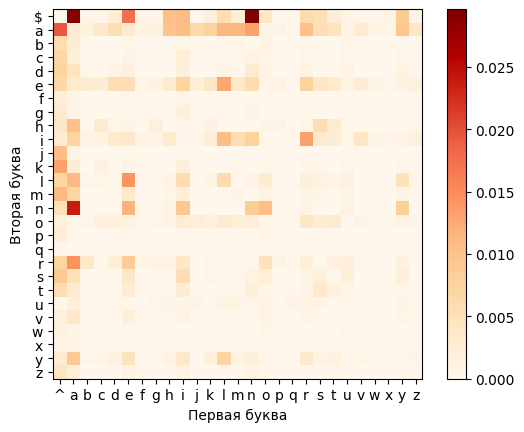

In [ ]:
# create DataFrame
df = pd.DataFrame(columns=sorted(set([b[0] for b in bigram_probs.keys()])), index=sorted(set([b[1] for b in bigram_probs.keys()])))
for b, p in bigram_probs.items():
    df.loc[b[1], b[0]] = p
df = df.astype(float).fillna(0)

# plot heatmap
plt.imshow(df, cmap='OrRd', interpolation='nearest')
plt.xticks(range(len(df.columns)), df.columns)
plt.yticks(range(len(df.index)), df.index)
plt.colorbar()

# add x-axis and y-axis labels
plt.xlabel('Первая буква')
plt.ylabel('Вторая буква')

plt.show()

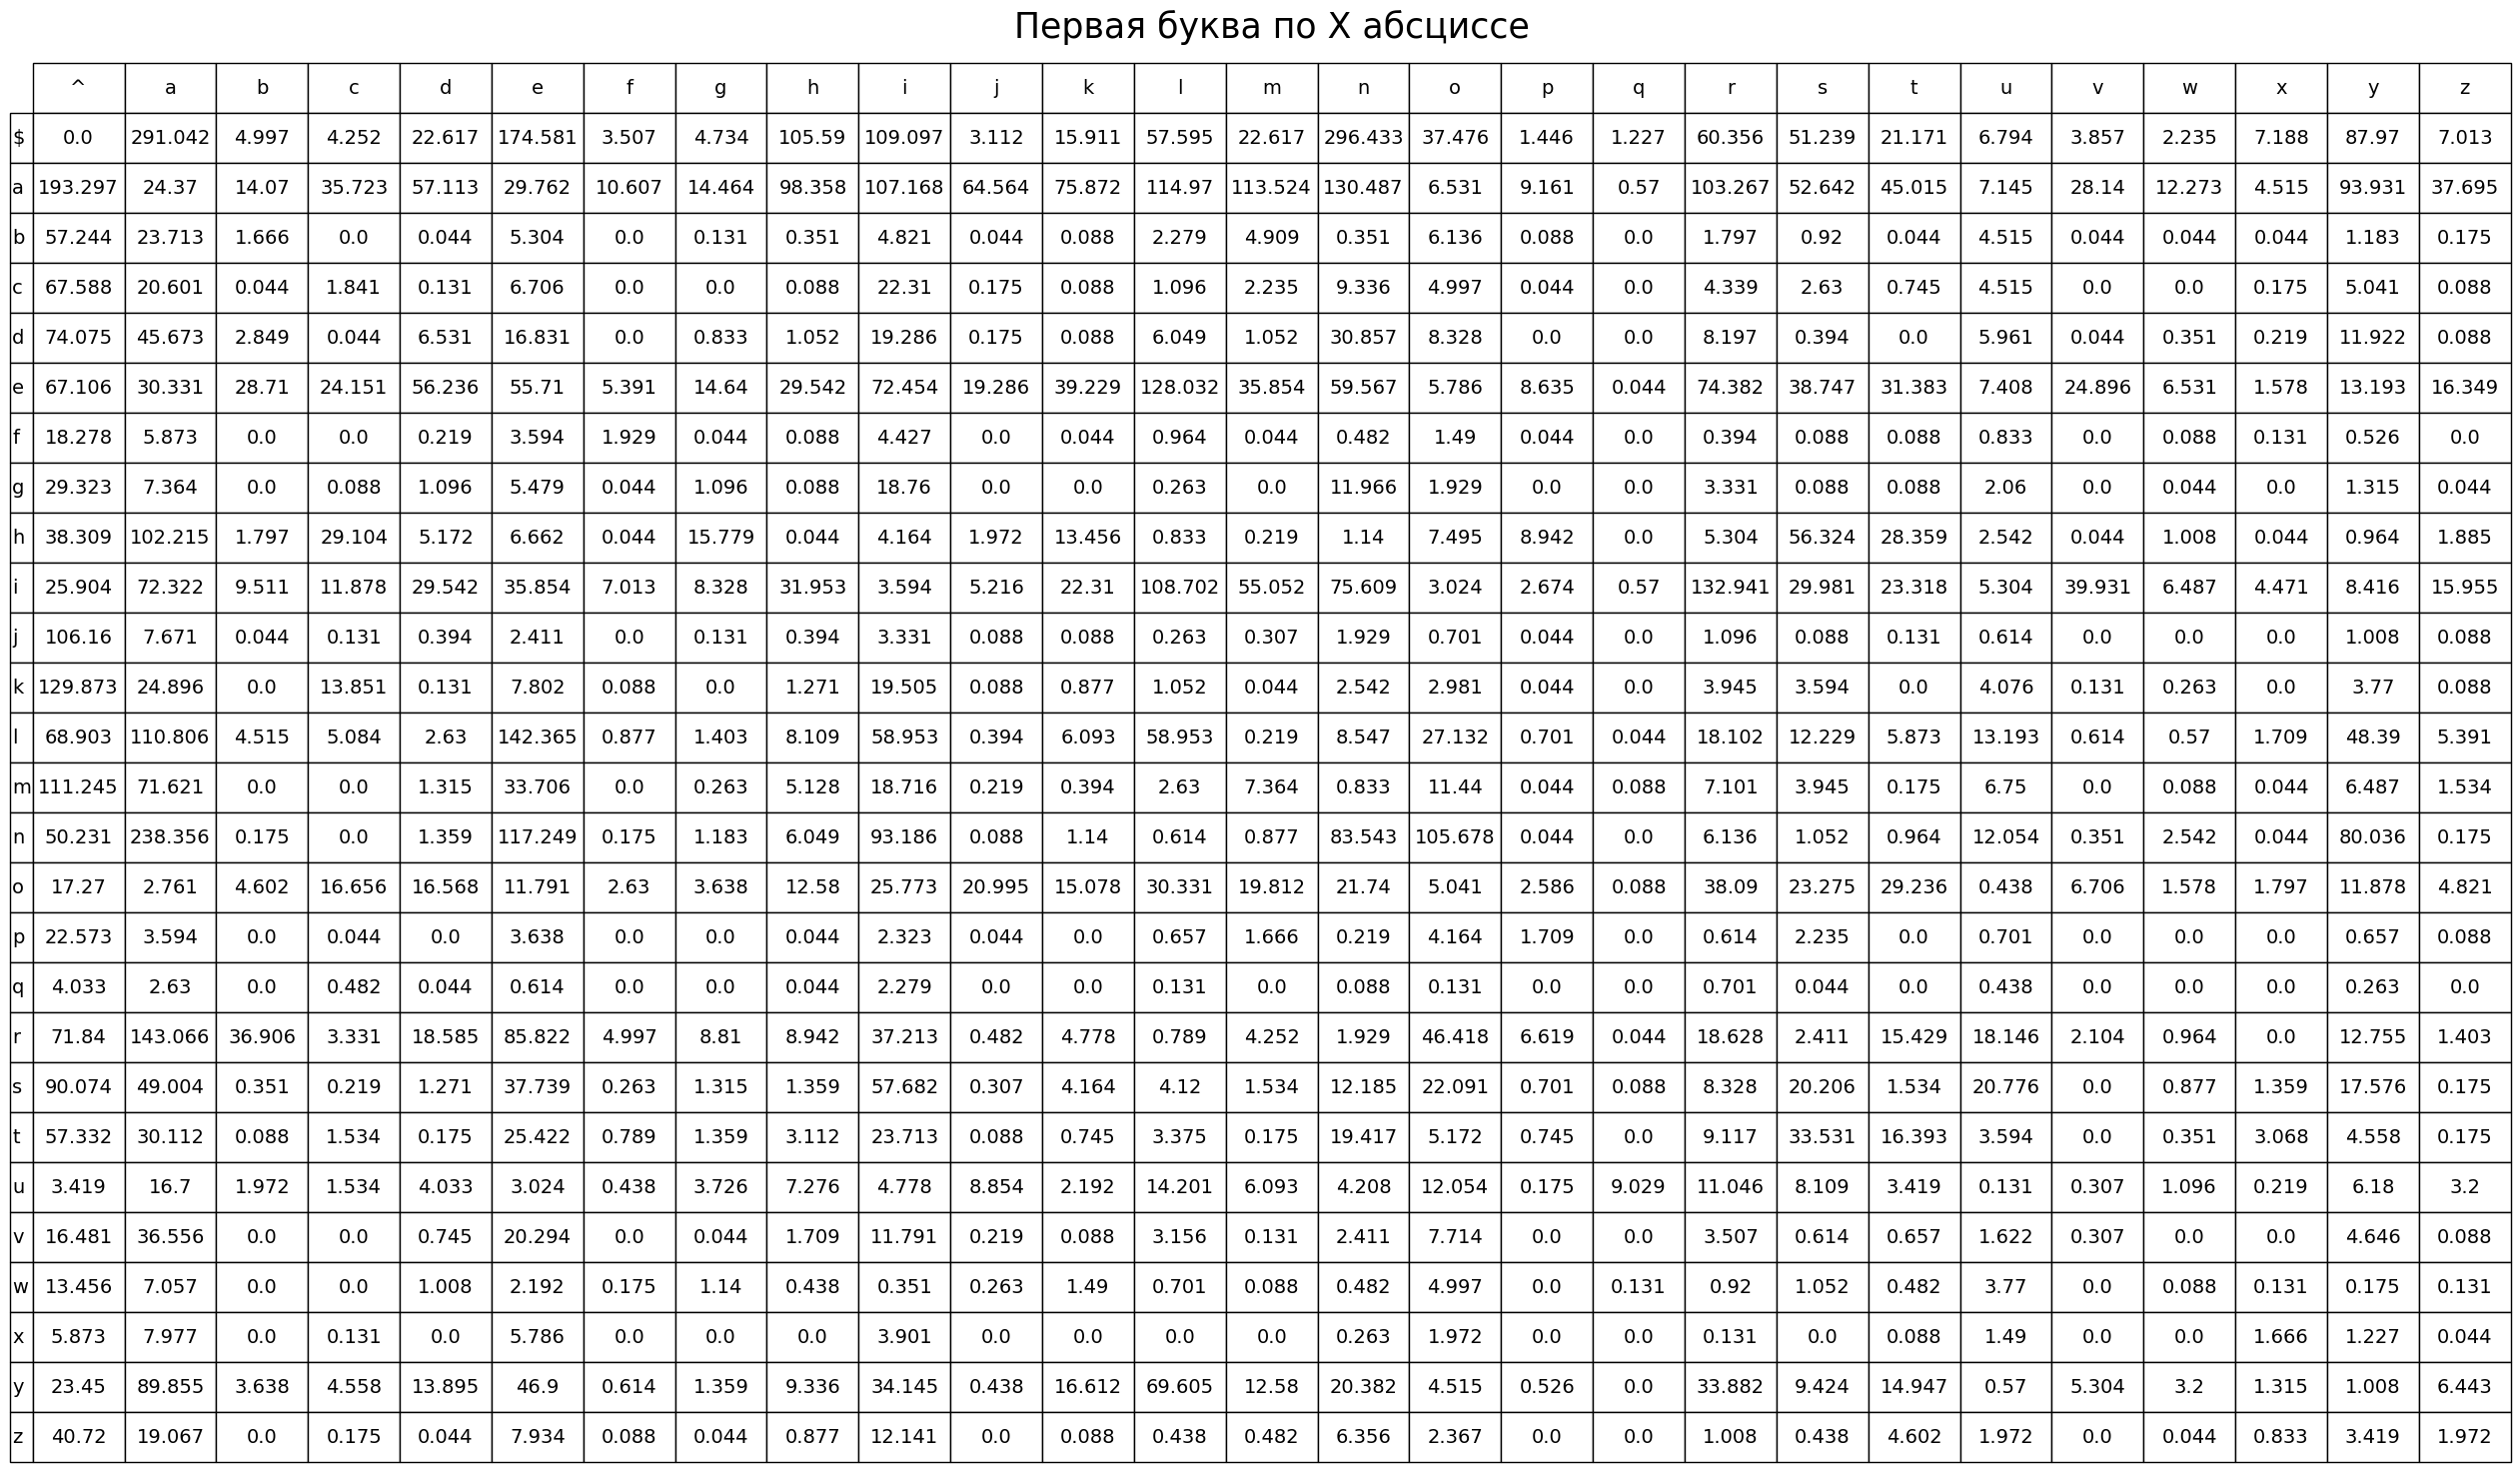

In [ ]:
# create DataFrame
df = pd.DataFrame(columns=sorted(set([b[0] for b in bigram_probs.keys()])), 
                  index=sorted(set([b[1] for b in bigram_probs.keys()])))

for b, p in bigram_probs.items():
    df.loc[b[1], b[0]] = p * 10000  # multiply by 10000
df = df.astype(float).round(3)  # round to 2 decimal places
df = df.fillna(0)

# plot table
fig, ax = plt.subplots()
ax.set_axis_off()
table = ax.table(cellText=df.values, 
                 colLabels=df.columns, 
                 rowLabels=df.index, 
                 loc='center', 
                 cellLoc='center')

ax.set_title("Первая буква по X абсциссе", fontsize=25, y=2.5, pad=-10)

table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(5, 3)
plt.show()

In [ ]:
import seaborn as sns

cm = sns.light_palette('green', as_cmap=True)

s = df.style.set_precision(3).background_gradient(cmap=cm, low=0, high=1, axis=0)
s

<ipython-input-12-b5e50d0727da>:5: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  s = df.style.set_precision(3).background_gradient(cmap=cm, low=0, high=1, axis=0)


,^,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z
$,0.000,291.042,4.997,4.252,22.617,174.581,3.507,4.734,105.590,109.097,3.112,15.911,57.595,22.617,296.433,37.476,1.446,1.227,60.356,51.239,21.171,6.794,3.857,2.235,7.188,87.970,7.013
a,193.297,24.370,14.070,35.723,57.113,29.762,10.607,14.464,98.358,107.168,64.564,75.872,114.970,113.524,130.487,6.531,9.161,0.570,103.267,52.642,45.015,7.145,28.140,12.273,4.515,93.931,37.695
b,57.244,23.713,1.666,0.000,0.044,5.304,0.000,0.131,0.351,4.821,0.044,0.088,2.279,4.909,0.351,6.136,0.088,0.000,1.797,0.920,0.044,4.515,0.044,0.044,0.044,1.183,0.175
c,67.588,20.601,0.044,1.841,0.131,6.706,0.000,0.000,0.088,22.310,0.175,0.088,1.096,2.235,9.336,4.997,0.044,0.000,4.339,2.630,0.745,4.515,0.000,0.000,0.175,5.041,0.088
d,74.075,45.673,2.849,0.044,6.531,16.831,0.000,0.833,1.052,19.286,0.175,0.088,6.049,1.052,30.857,8.328,0.000,0.000,8.197,0.394,0.000,5.961,0.044,0.351,0.219,11.922,0.088
e,67.106,30.331,28.710,24.151,56.236,55.710,5.391,14.640,29.542,72.454,19.286,39.229,128.032,35.854,59.567,5.786,8.635,0.044,74.382,38.747,31.383,7.408,24.896,6.531,1.578,13.193,16.349
f,18.278,5.873,0.000,0.000,0.219,3.594,1.929,0.044,0.088,4.427,0.000,0.044,0.964,0.044,0.482,1.490,0.044,0.000,0.394,0.088,0.088,0.833,0.000,0.088,0.131,0.526,0.000
g,29.323,7.364,0.000,0.088,1.096,5.479,0.044,1.096,0.088,18.760,0.000,0.000,0.263,0.000,11.966,1.929,0.000,0.000,3.331,0.088,0.088,2.060,0.000,0.044,0.000,1.315,0.044
h,38.309,102.215,1.797,29.104,5.172,6.662,0.044,15.779,0.044,4.164,1.972,13.456,0.833,0.219,1.140,7.495,8.942,0.000,5.304,56.324,28.359,2.542,0.044,1.008,0.044,0.964,1.885
i,25.904,72.322,9.511,11.878,29.542,35.854,7.013,8.328,31.953,3.594,5.216,22.310,108.702,55.052,75.609,3.024,2.674,0.570,132.941,29.981,23.318,5.304,39.931,6.487,4.471,8.416,15.955


In [ ]:
#pip install dataframe_image -q

In [ ]:
#import dataframe_image as dfi

#dfi.export(s,"green_dataframe.png")

# Нейронка TensorFlow keras

In [ ]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
from sklearn.model_selection import train_test_split

In [ ]:
# Создадим DataFrame, чтобы далее было удобнее работать 
df_names = pd.DataFrame({'name': names})

In [ ]:
df_names.name = df_names.name.apply(lambda x: x.lower())

In [ ]:
df_names=pd.DataFrame({'name': df_names.name.unique()})

In [ ]:
df_names.head()

,name
0,emma
1,olivia
2,ava
3,isabella
4,sophia


In [ ]:
lenght_list=[]
for l in df_names.name:
    lenght_list.append(len(l))
max_len = np.max(lenght_list)
max_len

15

In [ ]:
# Append '\t' to input to delay target by 1 timstamp
df_names['name'] = df_names.name.apply(lambda x:'\t'+x)

In [ ]:
# Append \n to notify end of word
df_names['target'] = df_names.name.apply(lambda x:x[1:len(x)]+'\n')

In [ ]:
df_names.head()

,name,target
0,\temma,emma\n
1,\tolivia,olivia\n
2,\tava,ava\n
3,\tisabella,isabella\n
4,\tsophia,sophia\n


In [ ]:
# Get the vocab dict
all_chars=set()
for name in df_names.name:
    for c in name:
        if c not in all_chars:
            all_chars.add(c)
all_chars.add('\n')

# Получим индексы
char_to_ix = { ch:i for i,ch in enumerate(sorted(all_chars)) }
ix_to_char = { i:ch for i,ch in enumerate(sorted(all_chars)) }

In [ ]:
# 
input_data = np.zeros((len(df_names.name), max_len+1, 28),dtype='float32')
output_data = np.zeros((len(df_names.name), max_len+1, 28),dtype='float32')

In [ ]:
# Generate input and output data
for i, x in enumerate(df_names.name):
    for t, ch in enumerate(x):
        input_data[i, t, char_to_ix[ch]] = 1.
for i, x in enumerate(df_names.target):
    for t, ch in enumerate(x):
        output_data[i,t, char_to_ix[ch]] = 1.

In [ ]:
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.callbacks import LambdaCallback
from keras.layers import TimeDistributed
from keras.optimizers import RMSprop
from keras.utils import plot_model

In [ ]:
model = Sequential()
model.add(LSTM(50, input_shape=(max_len+1, len(all_chars)), return_sequences=True))
model.add(TimeDistributed(Dense(len(all_chars))))
model.add(TimeDistributed(Activation('softmax')))
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16, 50)            15800     
                                                                 
 time_distributed (TimeDistr  (None, 16, 28)           1428      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 28)           0         
 tributed)                                                       
                                                                 
Total params: 17,228
Trainable params: 17,228
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import tensorflow as tf
import tensorflow 

from tensorflow import keras
keras.models.Model.predict_proba = keras.models.Model.predict

In [ ]:
# Sampling function to generate new names
def generate_name():
    stop=False
    ch='\t'
    counter=1
    target_seq = np.zeros((1, max_len+1, 28))
    target_seq[0, 0, char_to_ix[ch]] = 1.
    while stop == False and counter < 10:
        probs = model.predict(target_seq, verbose=0)[:,counter-1,:]
        c= np.random.choice(sorted(list(all_chars)), replace =False,p=probs.reshape(28))
        if c=='\n':
            stop=True
        else:
            ch=ch+c
            target_seq[0,counter , char_to_ix[c]] = 1.
            counter=counter+1
    return ch

In [ ]:
# Sampling function to generate new names
def onend(epoch, logs):
    if epoch%2==0 and epoch !=0:
        print('----- Generating text after Epoch: %d' % epoch)
        for i in range(0,10):
            print(generate_name())

In [ ]:
# fit the model
print_callback = LambdaCallback(on_epoch_end=onend)
model.fit(input_data, output_data, batch_size=32,epochs=3, callbacks=[print_callback])

Epoch 1/3
922/922 [==============================] - 22s 21ms/step - loss: 1.0007
Epoch 2/3
922/922 [==============================] - 26s 28ms/step - loss: 0.9389
Epoch 3/3
920/922 [============================>.] - ETA: 0s - loss: 0.9207----- Generating text after Epoch: 2
	raya
	luane
	adurshni
	kerenvi
	abmina
	annae
	ayliana
	yaslie
	miyan
	keagson
922/922 [==============================] - 27s 30ms/step - loss: 0.9207


In [ ]:
# save the trained weights
model.save_weights('name_generator_weights.h5')

# load the saved weights whenever you want to generate new names
model.load_weights('name_generator_weights.h5')

In [ ]:
# generate new names using the saved weights
for i in range(10):
    print(generate_name())

	lylie
	breighton
	kestyn
	denora
	ekainer
	anriac
	vaniah
	sarceo
	miaquee
	kleimber


# PyTorch

In [ ]:
import os
import time
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
#from torchsummary import summary

import string
from collections import Counter

In [ ]:
# Создадим DataFrame, чтобы далее было удобнее работать 
df_names = pd.DataFrame({'name': names})
df_names.name = df_names.name.apply(lambda x: x.lower() + '.')
df_names=pd.DataFrame({'name': df_names.name.unique()})

In [ ]:
df_names.head()

,name
0,emma.
1,olivia.
2,ava.
3,isabella.
4,sophia.


In [ ]:
print(df_names.shape)

(29494, 1)


In [ ]:
chars = "." + string.ascii_lowercase
num_chars = len(chars)
print(chars)
print(num_chars)

.abcdefghijklmnopqrstuvwxyz
27


In [ ]:
char_to_id = {c:i for i, c in enumerate(chars)}
id_to_char = {v:k for k, v in char_to_id.items()}
print(char_to_id)
print(id_to_char)

{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [ ]:
names_list = df_names['name'].tolist()
len(names_list)

29494

In [ ]:
max_length = len(max(names, key=len))
max_length

15

In [ ]:
class NamesDataset(Dataset):
    
    def __init__(self, names_list):
        self.names_list = names_list
        
    def __len__(self):
        return len(self.names_list)
    
    def __getitem__(self, idx):
        x_str = self.names_list[idx].ljust(max_length, ".")[:max_length]
        y_str = x_str[1:] + "."

        x = torch.zeros((max_length, num_chars))
        y = torch.zeros(max_length)
        for i, c in enumerate(x_str):
            x[i, char_to_id[c]] = 1
        for i, c in enumerate(y_str):
            y[i] = char_to_id[c]
      
        return x, y

In [ ]:
trainset = NamesDataset(names_list)

In [159]:
train_batch_size = 150

In [160]:
train_loader = DataLoader(trainset, batch_size=train_batch_size, shuffle=True)
print(len(train_loader))

169


In [161]:
train_iter = iter(train_loader)
X, Y = next(train_iter)
print(X.size(), Y.size())

torch.Size([175, 15, 27]) torch.Size([175, 15])


In [162]:
input_size = num_chars
hidden_size = 54
output_size = num_chars
num_layers = 1

In [163]:
class Model(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                             num_layers=num_layers, batch_first=True)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.fc3 = nn.Linear(output_size, output_size)

    def forward(self, X, states):
        ht, ct = states
        batch_size = X.size(0)
        out, (ht, ct) = self.lstm1(X, (ht, ct))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out, (ht, ct) # out: Size([batch_size, max_length, num_chars])


In [164]:
model = Model(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers)

In [165]:
device = torch.device('cpu')

In [166]:
model = nn.DataParallel(model)
model = model.to(device)

In [167]:
ht = torch.zeros((num_layers, train_batch_size, hidden_size)).to(device)
ct = torch.zeros((num_layers, train_batch_size, hidden_size)).to(device)

In [168]:
lr = 0.005
step_size = len(train_loader) * 1
gamma = 0.95
print(step_size)

169


In [169]:
criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=step_size, gamma=gamma)

In [170]:
def generate_name(model, start='a', k=5):
    
    if len(start) >= max_length:
        return name
    
    with torch.no_grad():
        
        ht = torch.zeros((num_layers, 1, hidden_size)).to(device)
        ct = torch.zeros((num_layers, 1, hidden_size)).to(device)
        length = 0
        name = start

        for char in start:
            X = torch.zeros((1, 1, num_chars)) # [batch_size, timestep, num_chars]
            X[0, 0, char_to_id[char]] = 1
            out, (ht, ct) = model(X, (ht, ct))
            length += 1
        vals, idxs = torch.topk(out[0], k) # 0 -> first eg in a batch
        idx = np.random.choice(idxs.cpu().numpy()[0]) # 0 -> first...
        char = id_to_char[idx]
        vals, idxs = torch.topk(out[0], k) # 0 -> first eg in a batch
        idx = np.random.choice(idxs.cpu().numpy()[0]) # 0 -> first...
        char = id_to_char[idx]
        
        while char != "." and length <= max_length-1:
            X = torch.zeros((1, 1, num_chars)) # [batch_size, timestep, num_chars]
            X[0, 0, char_to_id[char]] = 1
            out, (ht, ct) = model(X, (ht, ct))
            vals, idxs = torch.topk(out[0], k) # 0 -> first eg in a batch
            idx = np.random.choice(idxs.cpu().numpy()[0]) # 0 -> first...
            char = id_to_char[idx]
            length += 1
            name += char

        if name[-1] != ".":
            name += "."
    
    return name

In [127]:
def sampler(model, start='a', n=10, k=5, only_new=False):
    
    names = []
    cnt = 0
    while cnt <= n:
        name = generate_name(model=model, start=start, k=k)
        if only_new: 
            if name not in names_list and name not in names:
                names.append(name)
                cnt += 1

        else:
            if name not in names:
                names.append(name)
                cnt += 1
    names = [name[:-1].title() for name in names]
    
    return names

In [128]:
def random_sampler(model, start='a', n=10, k=5, only_new=False):

    names = []
    cnt = 0
    while cnt <= n:
        start = random.choice(string.ascii_lowercase)
        name = generate_name(model=model, start=start, k=k)
        if only_new: 
            if name not in names_list and name not in names:
                names.append(name)
                cnt += 1

        else:
            if name not in names:
                names.append(name)
                cnt += 1
    names = [name[:-1].title() for name in names]
    
    return names

In [180]:
epochs = 40
print_every_n_epochs = epochs // 10

In [181]:
epoch_losses = []
epoch_lrs = []
iteration_losses = []
iteration_lrs = []

for epoch in tqdm(range(1, epochs+1), desc="Epochs"):
    epoch_loss = 0
    epoch_lr = 0

    for i, (X, Y) in tqdm(enumerate(train_loader, 1), total=len(train_loader), desc="Epoch-{}".format(epoch)):
    #for i, (X, Y) in enumerate(train_loader, 1):
        X, Y = X.to(device), Y.to(device)
        
        ht = torch.zeros((num_layers, X.size(0), hidden_size)).to(device)
        ct = torch.zeros((num_layers, X.size(0), hidden_size)).to(device)

        optimizer.zero_grad()
        Y_pred_logits, (ht, ct) = model(X, (ht, ct))
        Y_pred_logits = Y_pred_logits.transpose(1, 2) # Check Loss Doc: [N, d1, C] -> [N, C, d1]

        loss = criterion(Y_pred_logits, Y.long())
        loss.backward(retain_graph=True)
        optimizer.step()
        lr_scheduler.step()
        
        iteration_losses.append(loss.item())
        iteration_lrs.append(lr_scheduler.get_lr()[0])
        epoch_loss += loss.item()
        epoch_lr += lr_scheduler.get_lr()[0]

    epoch_loss /= len(train_loader)
    epoch_lr /= len(train_loader)
    epoch_losses.append(epoch_loss)
    epoch_lrs.append(epoch_lr)
    
    if epoch % print_every_n_epochs == 0:    
        message = "Epoch:{}    Loss:{}    LR:{}".format(epoch, epoch_loss, epoch_lr)
        print(message)
        names = sampler(model, start='jo', n=10, k=10, only_new=False)
        print(names)

Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch-1:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch-2:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch-3:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch-4:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch:4    Loss:0.7923539397279187    LR:0.0025652296219265173
['Joienoa', 'Josylueleigrs', 'Joatar', 'Joahiugssynting', 'Joviohitieraway', 'Joi', 'Jo', 'Johmyrennyawdeo', 'Joushmoughe', 'Jolannoupworiso', 'Jortul']


Epoch-5:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch-6:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch-7:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch-8:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch:8    Loss:0.7798326061322138    LR:0.002089395559744292
['Joysaenio', 'Jo', 'Joonerousynedis', 'Joid', 'Jonutisleisisir', 'Jotullyuwyeup', 'Joe', 'Josto', 'Joustaloropytit', 'Jodeseyuhopanub', 'Jonsobww']


Epoch-9:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch-10:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch-11:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch-12:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch:12    Loss:0.771119079293584    LR:0.001701825742133979
['Jorniyasutleagr', 'Jore', 'Jo', 'Jolbrcysssoki', 'Jorielthemwniel', 'Jolcagltylewysa', 'Jomnyst', 'Jolt', 'Joinistoslhunaa', 'Jogymty', 'Jorin']


Epoch-13:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch-14:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch-15:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch-16:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch:16    Loss:0.7649593977533149    LR:0.0013861477033790081
['Joykaresyem', 'Joo', 'Joaro', 'Joetmirdnyteshe', 'Josodeebitleete', 'Jode', 'Jonci', 'Jo', 'Joianehlwedamry', 'Joorei', 'Jooinnnwutlo']


Epoch-17:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch-18:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch-19:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch-20:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch:20    Loss:0.7601465688654657    LR:0.001129025967825353
['Jodleerowiti', 'Jogomashann', 'Jodn', 'Johovuskynderdh', 'Jolil', 'Joencyleaglaung', 'Josoabrwukemara', 'Joa', 'Joassyss', 'Jorate', 'Joisy']


Epoch-21:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch-22:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch-23:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch-24:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch:24    Loss:0.7565513344911429    LR:0.0009195987072060423
['Joo', 'Johoween', 'Jolyespupiopy', 'Josobu', 'Joen', 'Jov', 'Jo', 'Jolyetc', 'Joyett', 'Joral', 'Joyshussye']


Epoch-25:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch-26:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch-27:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch-28:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch:28    Loss:0.7537662207022221    LR:0.0007490188945112426
['Jos', 'Joni', 'Joyac', 'Joesaishw', 'Jooav', 'Joahirkonast', 'Jou', 'Joeevsiertsaglu', 'Jonsobwnd', 'Joszeal', 'Jol']


Epoch-29:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch-30:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch-31:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch-32:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch:32    Loss:0.7515208036941889    LR:0.0006100805709474965
['Jozale', 'Jooa', 'Joma', 'Jomcubuemwm', 'Joarly', 'Joyiuco', 'Joemyrosouee', 'Joynia', 'Jon', 'Jobeegly', 'Josabbsalyngo']


Epoch-33:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch-34:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch-35:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch-36:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch:36    Loss:0.7500189387586695    LR:0.0004969144380403068
['Jodnornc', 'Joimcynnchisold', 'Joyniret', 'Jooniksendetshu', 'Jonio', 'Joaeetydhiehwah', 'Jonatundnyohoub', 'Joeiceh', 'Joumeme', 'Joickiritshias', 'Joloug']


Epoch-37:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch-38:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch-39:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch-40:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch:40    Loss:0.748554001545765    LR:0.0004047399154990672
['Jodisenoua', 'Josarchiebeppyo', 'Jomettselym', 'Jogtysogosiepw', 'Joayesydsoumwek', 'Joslisstay', 'Job', 'Jod', 'Joarousenee', 'Joadyri', 'Jowymoswnocopom']


In [182]:
# upload external file before import
from google.colab import files
files.upload()
import helper

In [183]:
torch.save(model.state_dict(), 'PyTorch_RNN.pth')

# download checkpoint file
files.download('PyTorch_RNN.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [184]:
state_dict = torch.load('PyTorch_RNN.pth')
print(state_dict.keys())

odict_keys(['module.lstm1.weight_ih_l0', 'module.lstm1.weight_hh_l0', 'module.lstm1.bias_ih_l0', 'module.lstm1.bias_hh_l0', 'module.fc2.weight', 'module.fc2.bias', 'module.fc3.weight', 'module.fc3.bias'])


In [185]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [186]:
names = sampler(model, start='t', n=10, k=5, only_new=True)
print(names)

['Tvyouk', 'Temomieuse', 'Tly', 'Trri', 'Tvia', 'Tran', 'Tonall', 'Tnciosa', 'Tvorietoni', 'Tleiahahannese', 'Tlanah']


In [187]:
names = sampler(model, start='su', n=10, k=5, only_new=True)
print(names)

['Suiahn', 'Sute', 'Suab', 'Suy', 'Suyir', 'Sumolynaes', 'Suai', 'Sui', 'Sumariahsudabul', 'Suahmelliahaunn', 'Suyashew']


In [189]:
names = random_sampler(model, n=10, k=5, only_new=True)
print(names)

['Kiliy', 'Jralyanand', 'Yhi', 'Rvy', 'Hreet', 'Rzymo', 'Yssylle', 'Glesta', 'Ymrynna', 'Sahri', 'Vshamm']
